In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
warnings.filterwarnings("ignore")




2024-11-30 16:26:13.576279: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-30 16:26:13.593136: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733005573.610399 2375943 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733005573.615701 2375943 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 16:26:13.634036: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
from google.cloud import storage

# Initialize the Google Cloud clients
client = storage.Client()

# Specify your bucket and blob (file) path
bucket_name = 'weather_data_bug_squashers'
blob_name = 'weather_cleaned.csv'

# Get the bucket and the blob
bucket = client.get_bucket(bucket_name)
blob = bucket.blob(blob_name)

# Download the file to the local runtime
blob.download_to_filename('weather_cleaned.csv')

ModuleNotFoundError: No module named 'google.cloud'

In [2]:
import psutil

# Get total and available memory
total_memory = psutil.virtual_memory().total / (1024 ** 3)  # in GB
available_memory = psutil.virtual_memory().available / (1024 ** 3)  # in GB

print(f"Total RAM: {total_memory:.2f} GB")
print(f"Available RAM: {available_memory:.2f} GB")


Total RAM: 754.39 GB
Available RAM: 733.05 GB


In [2]:
df=pd.read_csv("weather_cleaned.csv")

In [3]:
df.head()

,time,temp_2m,humidity_2m,dew_point_2m,precip,snowfall,snow_depth,msl_pressure,surface_pressure,cloud_cover_low,...,weather_Drizzle: Moderate,weather_Mainly clear,weather_Overcast,weather_Partly cloudy,weather_Rain: Heavy,weather_Rain: Moderate,weather_Rain: Slight,weather_Snow fall: Heavy,weather_Snow fall: Moderate,weather_Snow fall: Slight
0,2000-01-01 00:00:00,41.9,69,32.4,0.0,0.0,0.0,1019.6,1001.7,0,...,False,False,False,False,False,False,False,False,False,False
1,2000-01-01 01:00:00,39.5,74,31.9,0.0,0.0,0.0,1019.1,1001.1,0,...,False,False,False,False,False,False,False,False,False,False
2,2000-01-01 02:00:00,37.7,78,31.4,0.0,0.0,0.0,1019.1,1001.0,0,...,False,False,False,False,False,False,False,False,False,False
3,2000-01-01 03:00:00,36.4,80,30.9,0.0,0.0,0.0,1018.9,1000.8,0,...,False,False,False,False,False,False,False,False,False,False
4,2000-01-01 04:00:00,35.5,82,30.4,0.0,0.0,0.0,1019.0,1000.8,0,...,False,False,False,False,False,False,False,False,False,False


In [4]:
import pandas as pd
import numpy as np
import torch

# Convert boolean columns to integers (0 and 1)
df = df.applymap(lambda x: int(x) if isinstance(x, bool) else x)

# Encode the city names as integers
df['city_idx'] = df['location_city'].astype('category').cat.codes  # Numeric index for each city
features = ['humidity_2m', 'dew_point_2m', 'precip', 'snowfall', 'snow_depth', 
            'msl_pressure', 'surface_pressure', 'cloud_cover_low', 'cloud_cover_mid',
            'cloud_cover_high', 'et0', 'vpd', 'wind_speed_10m', 'wind_dir_10m', 
            'soil_temp_0_7cm', 'soil_moisture_0_7cm', 'latitude', 'longitude'] + \
           [col for col in df.columns if col.startswith('weather_')]

target = 'temp_2m'
T = 3  # Number of timesteps
input_dim = len(features)

# Lists to hold training and testing data across all cities
X_train_list, y_train_list, city_train_list = [], [], []
X_test_list, y_test_list, city_test_list = [], [], []

# To compute normalization statistics
all_train_data = []

# Process each city independently
for city_id, city_data in df.groupby('city_idx'):
    city_data = city_data.sort_values(by='time').reset_index(drop=True)
    input_data = city_data[features].values
    targets = city_data[target].values
    
    # Determine train size for the current city
    N = len(input_data) - T  # Total number of sequences
    train_size = int(0.90 * N)
    
    # Split data for normalization calculation (only on training set)
    train_data = input_data[:train_size]
    all_train_data.append(train_data)  # Collect all training data for global normalization
    
    # Convert to torch tensors
    input_data_tensor = torch.tensor(input_data, dtype=torch.float32)
    target_tensor = torch.tensor(targets, dtype=torch.float32)
    
    # Initialize train and test tensors for this city
    X_train_city = torch.zeros((train_size, T, input_dim), dtype=torch.float32)
    y_train_city = torch.zeros((train_size, 1), dtype=torch.float32)
    X_test_city = torch.zeros((N - train_size, T, input_dim), dtype=torch.float32)
    y_test_city = torch.zeros((N - train_size, 1), dtype=torch.float32)
    
    # Prepare training sequences
    for t in range(train_size):
        X_train_city[t] = input_data_tensor[t:t + T]
        y_train_city[t] = target_tensor[t + T]
    
    # Prepare testing sequences
    for i in range(N - train_size):
        t = i + train_size
        X_test_city[i] = input_data_tensor[t:t + T]
        y_test_city[i] = target_tensor[t + T]
    
    # Prepare city indices for train and test
    city_train_city = torch.full((train_size,), city_id, dtype=torch.long)
    city_test_city = torch.full((N - train_size,), city_id, dtype=torch.long)
    
    # Append city-specific data to the main lists
    X_train_list.append(X_train_city)
    y_train_list.append(y_train_city)
    city_train_list.append(city_train_city)
    
    X_test_list.append(X_test_city)
    y_test_list.append(y_test_city)
    city_test_list.append(city_test_city)

# Concatenate all training data for normalization calculation
all_train_data = np.vstack(all_train_data)
train_mean = all_train_data.mean(axis=0)
train_std = all_train_data.std(axis=0)

# Concatenate all cities’ data to form the final tensors
X_train = torch.cat(X_train_list, dim=0)
y_train = torch.cat(y_train_list, dim=0)
city_train = torch.cat(city_train_list, dim=0)

X_test = torch.cat(X_test_list, dim=0)
y_test = torch.cat(y_test_list, dim=0)
city_test = torch.cat(city_test_list, dim=0)

# Normalize X_train and X_test
train_mean_tensor = torch.tensor(train_mean, dtype=torch.float32)
train_std_tensor = torch.tensor(train_std, dtype=torch.float32)

# Normalize along the feature dimension (last dimension)
X_train = (X_train - train_mean_tensor) / train_std_tensor
X_test = (X_test - train_mean_tensor) / train_std_tensor

# Print shapes to confirm the results
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("city_train shape:", city_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("city_test shape:", city_test.shape)


X_train shape: torch.Size([977490, 3, 31])
y_train shape: torch.Size([977490, 1])
city_train shape: torch.Size([977490])
X_test shape: torch.Size([108615, 3, 31])
y_test shape: torch.Size([108615, 1])
city_test shape: torch.Size([108615])


# Hyperparameter tuning

# Timeseries GridSeach-Cross Validation

In [38]:
# Randomly sample 10% of the data for tuning
sample_fraction = 0.1

# Subsample indices
train_indices = torch.randperm(X_train.size(0))[:int(sample_fraction * X_train.size(0))]
test_indices = torch.randperm(X_test.size(0))[:int(sample_fraction * X_test.size(0))]

# Create smaller datasets
X_train_sample = X_train[train_indices]
y_train_sample = y_train[train_indices]
city_train_sample = city_train[train_indices]



In [39]:
y_train_sample.shape

torch.Size([97749, 1])

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import TimeSeriesSplit
from itertools import product
import numpy as np

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define the model
class LSTMModelWithEmbedding(nn.Module):
    def __init__(self, input_dim, num_cities, embedding_dim, hidden_size, dropout):
        super().__init__()
        self.city_embedding = nn.Embedding(num_embeddings=num_cities, embedding_dim=embedding_dim)
        self.lstm = nn.LSTM(
            input_size=input_dim + embedding_dim,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout)
        self.linear1 = nn.Linear(hidden_size * 2, 64)
        self.linear2 = nn.Linear(64, 8)
        self.output_linear = nn.Linear(8, 1)

    def forward(self, x, city_idx):
        city_emb = self.city_embedding(city_idx).unsqueeze(1).expand(-1, x.size(1), -1)
        x = torch.cat([x, city_emb], dim=2)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Output from the last timestep
        x = self.dropout(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.output_linear(x)
        return x

# Hyperparameter Grid
param_grid = {
    'embedding_dim': [4, 8, 16],
    'hidden_size': [64, 128, 256],
    'dropout': [0.2, 0.5],
    'learning_rate': [1e-3, 1e-4],
    'batch_size': [64, 128, 512]
}

# TimeSeriesSplit
n_splits_per_city = 5
tscv = TimeSeriesSplit(n_splits=n_splits_per_city)

# Prepare city-wise cross-validation splits
city_splits = []

for city in city_train.unique().tolist():
    city_mask = (city_train == city)
    city_X = X_train[city_mask]
    city_y = y_train[city_mask]

    # Subsample 50% of the data for faster grid search
    subsample_size = int(0.5 * len(city_X))
    subsample_indices = torch.arange(len(city_X))[:subsample_size]
    city_X = city_X[subsample_indices]
    city_y = city_y[subsample_indices]

    for train_idx, val_idx in tscv.split(city_X):
        city_splits.append((
            city_X[train_idx], city_X[val_idx],
            city_y[train_idx], city_y[val_idx],
            torch.full((len(train_idx),), city, dtype=torch.long),
            torch.full((len(val_idx),), city, dtype=torch.long)
        ))

# Group city splits into global folds
n_global_folds = 5
global_folds = [[] for _ in range(n_global_folds)]

for i, split in enumerate(city_splits):
    global_folds[i % n_global_folds].append(split)

combined_folds = []
for fold in global_folds:
    X_train_fold = torch.cat([f[0] for f in fold])
    X_val_fold = torch.cat([f[1] for f in fold])
    y_train_fold = torch.cat([f[2] for f in fold])
    y_val_fold = torch.cat([f[3] for f in fold])
    city_train_fold = torch.cat([f[4] for f in fold])
    city_val_fold = torch.cat([f[5] for f in fold])

    combined_folds.append((X_train_fold, X_val_fold, y_train_fold, y_val_fold, city_train_fold, city_val_fold))

# Perform Grid Search
best_val_loss = float('inf')
best_params = None
# Calculate total combinations
total_combinations = len(list(product(*param_grid.values())))

for params in product(*param_grid.values()):
    embedding_dim, hidden_size, dropout, learning_rate, batch_size = params
    print(f"Remaining combinations: {remaining_combinations - 1}/{total_combinations}")
    
    # Update remaining combinations
    remaining_combinations -= 1

    fold_val_losses = []

    for X_train_fold, X_val_fold, y_train_fold, y_val_fold, city_train_fold, city_val_fold in combined_folds:
        train_dataset = torch.utils.data.TensorDataset(X_train_fold, y_train_fold, city_train_fold)
        val_dataset = torch.utils.data.TensorDataset(X_val_fold, y_val_fold, city_val_fold)

        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Initialize model
        model = LSTMModelWithEmbedding(
            input_dim=X_train.shape[2],
            num_cities=city_train.max().item() + 1,
            embedding_dim=embedding_dim,
            hidden_size=hidden_size,
            dropout=dropout
        ).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        loss_fn = nn.MSELoss()

        # Train
        for epoch in range(5):
            model.train()
            for X_batch, y_batch, city_batch in train_loader:
                X_batch, y_batch, city_batch = X_batch.to(device), y_batch.to(device), city_batch.to(device)
                optimizer.zero_grad()
                output = model(X_batch, city_batch).squeeze()
                loss = loss_fn(output, y_batch)
                loss.backward()
                optimizer.step()

        # Validate
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch, city_batch in val_loader:
                X_batch, y_batch, city_batch = X_batch.to(device), y_batch.to(device), city_batch.to(device)
                output = model(X_batch, city_batch).squeeze()
                loss = loss_fn(output, y_batch)
                val_loss += loss.item() * X_batch.size(0)
        val_loss /= len(val_loader.dataset)
        fold_val_losses.append(val_loss)

    avg_val_loss = np.mean(fold_val_losses)
    print(f"Average Validation Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_params = params
        torch.save(model.state_dict(), "best_model.pth")
        print(f"New Best Model Saved with Loss: {avg_val_loss:.4f}")

# Output Best Parameters
print(f"Best Hyperparameters: {best_params}")
print(f"Best Validation Loss: {best_val_loss:.4f}")


Using device: cuda
Testing hyperparameters: (4, 64, 0.2, 0.001, 64)
  Fold 1/15...
    Fold 1 Validation Loss: 454.2459
  Fold 2/15...
    Fold 2 Validation Loss: 1379.9966
  Fold 3/15...
    Fold 3 Validation Loss: 770.7548
  Fold 4/15...
    Fold 4 Validation Loss: 654.7343
  Fold 5/15...
    Fold 5 Validation Loss: 276.1660
  Fold 6/15...
    Fold 6 Validation Loss: 387.7853
  Fold 7/15...
    Fold 7 Validation Loss: 298.1789
  Fold 8/15...
    Fold 8 Validation Loss: 373.0687
  Fold 9/15...
    Fold 9 Validation Loss: 425.1070
  Fold 10/15...
    Fold 10 Validation Loss: 511.5176
  Fold 11/15...
    Fold 11 Validation Loss: 1517.6848
  Fold 12/15...
    Fold 12 Validation Loss: 986.2237
  Fold 13/15...
    Fold 13 Validation Loss: 942.6187
  Fold 14/15...
    Fold 14 Validation Loss: 1252.0203
  Fold 15/15...
    Fold 15 Validation Loss: 623.0271
  Average Validation Loss for Hyperparameters: 723.5420
  New Best Model Saved with Loss: 723.5420
Testing hyperparameters: (4, 64, 0.2, 

KeyboardInterrupt: 

# Randomsearch CV 

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import random
from itertools import product

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define the model
class LSTMModelWithEmbedding(nn.Module):
    def __init__(self, input_dim, num_cities, embedding_dim, hidden_size, dropout):
        super().__init__()
        self.city_embedding = nn.Embedding(num_embeddings=num_cities, embedding_dim=embedding_dim)
        self.lstm = nn.LSTM(
            input_size=input_dim + embedding_dim,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout)
        self.linear1 = nn.Linear(hidden_size * 2, 64)
        self.linear2 = nn.Linear(64, 8)
        self.output_linear = nn.Linear(8, 1)

    def forward(self, x, city_idx):
        city_emb = self.city_embedding(city_idx).unsqueeze(1).expand(-1, x.size(1), -1)
        x = torch.cat([x, city_emb], dim=2)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Output from the last timestep
        x = self.dropout(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.output_linear(x)
        return x

# Hyperparameter Space
param_grid = {
    'embedding_dim': [4, 8, 16],
    'hidden_size': [64, 128, 256],
    'dropout': [0.2, 0.5],
    'learning_rate': [1e-3, 1e-4],
    'batch_size': [64, 128, 512]
}

# Generate all combinations
all_combinations = list(product(*param_grid.values()))

# Randomly sample a subset of combinations
n_random_samples = 25  # Number of random samples to test
random_combinations = random.sample(all_combinations, n_random_samples)

# TimeSeriesSplit
n_splits_per_city = 5
tscv = TimeSeriesSplit(n_splits=n_splits_per_city)

# Prepare city-wise cross-validation splits
city_splits = []

for city in city_train.unique().tolist():
    city_mask = (city_train == city)
    city_X = X_train[city_mask]
    city_y = y_train[city_mask]

    # Subsample 50% of the data for faster random search
    subsample_size = int(0.5 * len(city_X))
    subsample_indices = torch.arange(len(city_X))[:subsample_size]
    city_X = city_X[subsample_indices]
    city_y = city_y[subsample_indices]

    for train_idx, val_idx in tscv.split(city_X):
        city_splits.append((
            city_X[train_idx], city_X[val_idx],
            city_y[train_idx], city_y[val_idx],
            torch.full((len(train_idx),), city, dtype=torch.long),
            torch.full((len(val_idx),), city, dtype=torch.long)
        ))

# Group city splits into global folds
n_global_folds = 5
global_folds = [[] for _ in range(n_global_folds)]

for i, split in enumerate(city_splits):
    global_folds[i % n_global_folds].append(split)

combined_folds = []
for fold in global_folds:
    X_train_fold = torch.cat([f[0] for f in fold])
    X_val_fold = torch.cat([f[1] for f in fold])
    y_train_fold = torch.cat([f[2] for f in fold])
    y_val_fold = torch.cat([f[3] for f in fold])
    city_train_fold = torch.cat([f[4] for f in fold])
    city_val_fold = torch.cat([f[5] for f in fold])

    combined_folds.append((X_train_fold, X_val_fold, y_train_fold, y_val_fold, city_train_fold, city_val_fold))

# Perform Random Search
best_val_loss = float('inf')
best_params = None

for i, params in enumerate(random_combinations, start=1):
    embedding_dim, hidden_size, dropout, learning_rate, batch_size = params
    print(f"Testing combination {i}/{n_random_samples}: {params}")

    fold_val_losses = []

    for X_train_fold, X_val_fold, y_train_fold, y_val_fold, city_train_fold, city_val_fold in combined_folds:
        train_dataset = torch.utils.data.TensorDataset(X_train_fold, y_train_fold, city_train_fold)
        val_dataset = torch.utils.data.TensorDataset(X_val_fold, y_val_fold, city_val_fold)

        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Initialize model
        model = LSTMModelWithEmbedding(
            input_dim=X_train.shape[2],
            num_cities=city_train.max().item() + 1,
            embedding_dim=embedding_dim,
            hidden_size=hidden_size,
            dropout=dropout
        ).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        loss_fn = nn.MSELoss()

        # Train
        for epoch in range(5):
            model.train()
            for X_batch, y_batch, city_batch in train_loader:
                X_batch, y_batch, city_batch = X_batch.to(device), y_batch.to(device), city_batch.to(device)
                optimizer.zero_grad()
                output = model(X_batch, city_batch).squeeze()
                loss = loss_fn(output, y_batch)
                loss.backward()
                optimizer.step()

        # Validate
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch, city_batch in val_loader:
                X_batch, y_batch, city_batch = X_batch.to(device), y_batch.to(device), city_batch.to(device)
                output = model(X_batch, city_batch).squeeze()
                loss = loss_fn(output, y_batch)
                val_loss += loss.item() * X_batch.size(0)
        val_loss /= len(val_loader.dataset)
        fold_val_losses.append(val_loss)

    avg_val_loss = np.mean(fold_val_losses)
    print(f"Average Validation Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_params = params
        #torch.save(model.state_dict(), "best_model.pth")
        print(f"New Best Model Saved with Loss: {avg_val_loss:.4f}")

# Output Best Parameters
print(f"Best Hyperparameters: {best_params}")
print(f"Best Validation Loss: {best_val_loss:.4f}")


Using device: cuda
Testing combination 1/25: (8, 64, 0.2, 0.001, 128)
Average Validation Loss: 199.5928
New Best Model Saved with Loss: 199.5928
Testing combination 2/25: (8, 256, 0.5, 0.0001, 64)


KeyboardInterrupt: 

In [28]:
print(kf)

KFold(n_splits=5, random_state=42, shuffle=True)


# Hyperparameter tuning with optuna

In [14]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Objective Function for Optuna
def objective(trial):
    # Sample hyperparameters
    embedding_dim = trial.suggest_int("embedding_dim", 4, 16)
    hidden_size = trial.suggest_categorical("hidden_size", [64,128, 256])
    dropout = trial.suggest_float("dropout", 0.2, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [64,128, 512])

    n_splits_per_city = 5  # Split each city into 5 folds initially
    tscv = TimeSeriesSplit(n_splits=n_splits_per_city)

    # Collect all splits for grouping later
    city_splits = []

    for city in city_train.unique().tolist():  # Get unique city IDs
        city_mask = (city_train == city)
        city_X = X_train[city_mask]
        city_y = y_train[city_mask]
        
        # Subsample 10% of the data for training
        subsample_size = int(0.5 * len(city_X))  # 10% of the data
        subsample_indices = torch.arange(len(city_X))[:subsample_size]
        city_X = city_X[subsample_indices]
        city_y = city_y[subsample_indices]

        for train_idx, val_idx in tscv.split(city_X):
            city_splits.append((
                city_X[train_idx], city_X[val_idx],
                city_y[train_idx], city_y[val_idx],
                torch.full((len(train_idx),), city, dtype=torch.long),
                torch.full((len(val_idx),), city, dtype=torch.long)
            ))

    # Group all city splits into 5 global folds
    n_global_folds = 5
    global_folds = [[] for _ in range(n_global_folds)]

    for i, split in enumerate(city_splits):
        global_folds[i % n_global_folds].append(split)

    # Combine splits within each global fold
    combined_folds = []
    for fold in global_folds:
        X_train_fold = torch.cat([f[0] for f in fold])
        X_val_fold = torch.cat([f[1] for f in fold])
        y_train_fold = torch.cat([f[2] for f in fold])
        y_val_fold = torch.cat([f[3] for f in fold])
        city_train_fold = torch.cat([f[4] for f in fold])
        city_val_fold = torch.cat([f[5] for f in fold])

        combined_folds.append((X_train_fold, X_val_fold, y_train_fold, y_val_fold, city_train_fold, city_val_fold))

    # Perform training and validation
    fold_val_losses = []

    for X_train_fold, X_val_fold, y_train_fold, y_val_fold, city_train_fold, city_val_fold in combined_folds:
        train_dataset = torch.utils.data.TensorDataset(X_train_fold, y_train_fold, city_train_fold)
        val_dataset = torch.utils.data.TensorDataset(X_val_fold, y_val_fold, city_val_fold)

        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Initialize model
        model = LSTMModelWithEmbedding(
            input_dim=X_train.shape[2],
            num_cities=city_train.max().item() + 1,
            embedding_dim=embedding_dim,
            hidden_size=hidden_size,
            dropout=dropout
        ).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        loss_fn = nn.MSELoss()

        # Train
        for epoch in range(5):
            model.train()
            for X_batch, y_batch, city_batch in train_loader:
                X_batch, y_batch, city_batch = X_batch.to(device), y_batch.to(device), city_batch.to(device)
                optimizer.zero_grad()
                output = model(X_batch, city_batch).squeeze()
                loss = loss_fn(output, y_batch)
                loss.backward()
                optimizer.step()

        # Validate
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch, city_batch in val_loader:
                X_batch, y_batch, city_batch = X_batch.to(device), y_batch.to(device), city_batch.to(device)
                output = model(X_batch, city_batch).squeeze()
                loss = loss_fn(output, y_batch)
                val_loss += loss.item() * X_batch.size(0)
        val_loss /= len(val_loader.dataset)
        fold_val_losses.append(val_loss)

    avg_val_loss = np.mean(fold_val_losses)
    return avg_val_loss

# Optuna Study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, n_jobs=4)

# Best Hyperparameters
print("Best Hyperparameters:", study.best_params)
print("Best Validation Loss:", study.best_value)


[I 2024-11-30 17:42:27,865] A new study created in memory with name: no-name-9ebd499b-0fb7-4a21-9550-acc449165783


Using device: cuda


[I 2024-11-30 17:47:32,264] Trial 1 finished with value: 118.84406284630361 and parameters: {'embedding_dim': 10, 'hidden_size': 64, 'dropout': 0.44288125308872184, 'learning_rate': 0.00019695756171797036, 'batch_size': 512}. Best is trial 1 with value: 118.84406284630361.
[I 2024-11-30 17:48:36,199] Trial 0 finished with value: 126.37420243361416 and parameters: {'embedding_dim': 11, 'hidden_size': 128, 'dropout': 0.49353769964802, 'learning_rate': 0.0024570901181206564, 'batch_size': 512}. Best is trial 1 with value: 118.84406284630361.
[I 2024-11-30 17:50:03,715] Trial 3 finished with value: 138.19905673589432 and parameters: {'embedding_dim': 11, 'hidden_size': 256, 'dropout': 0.2035363517233028, 'learning_rate': 0.008857727672201776, 'batch_size': 512}. Best is trial 1 with value: 118.84406284630361.
[I 2024-11-30 17:51:27,612] Trial 4 finished with value: 125.07662785495492 and parameters: {'embedding_dim': 14, 'hidden_size': 128, 'dropout': 0.2881888902012745, 'learning_rate': 0

Best Hyperparameters: {'embedding_dim': 7, 'hidden_size': 64, 'dropout': 0.39902845484042315, 'learning_rate': 0.00010163954880259448, 'batch_size': 128}
Best Validation Loss: 93.12889932121159


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



print("Using device:", device)

# LSTM Model with Embedding
class LSTMModelWithEmbedding(nn.Module):
    def __init__(self, input_dim, num_cities, embedding_dim, hidden_size, dropout):
        super().__init__()
        self.city_embedding = nn.Embedding(num_embeddings=num_cities, embedding_dim=embedding_dim)
        self.lstm = nn.LSTM(
            input_size=input_dim + embedding_dim,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout)
        self.linear1 = nn.Linear(hidden_size * 2, 64)
        self.linear2 = nn.Linear(64, 8)
        self.output_linear = nn.Linear(8, 1)

    def forward(self, x, city_idx):
        city_emb = self.city_embedding(city_idx).unsqueeze(1).expand(-1, x.size(1), -1)
        x = torch.cat([x, city_emb], dim=2)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Output from the last timestep
        x = self.dropout(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.output_linear(x)
        return x


# Hyperparameters
input_dim = X_train.shape[2]  # Number of features
num_cities = city_train.max().item() + 1  # Total number of unique cities
epochs = 1000
hidden_size=128
dropout=0.39
batch_size = 64
embedding_dim = 7 # Dimension of the embedding layer

# Initialize model, criterion, and optimizer
model = LSTMModelWithEmbedding(input_dim=input_dim, num_cities=num_cities, embedding_dim=embedding_dim,hidden_size=hidden_size,dropout=dropout).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
city_train_tensor = torch.tensor(city_train, dtype=torch.long).to(device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
city_test_tensor = torch.tensor(city_test, dtype=torch.long).to(device)

# DataLoader for batching
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor, city_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor, city_test_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Using device: cuda


In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize variables to track the best model
best_val_loss = np.inf  # Set to infinity initially
best_checkpoint_path = "/home/research/a.naveen/denoise40/weather/lstm/best_model.pth"

train_losses=[]
val_losses=[]
# Training loop
for epoch in range(epochs):

    print(f"running_epoch {epoch}")
    model.train()
    train_loss = 0
    for X_batch, y_batch, city_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch, city_batch)
        loss = loss_fn(output.squeeze(), y_batch.squeeze())
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)

    # Validation step
    model.eval()
    val_loss = 0
    
    if epoch%5==0:
        with torch.no_grad():
            for X_batch, y_batch, city_batch in test_loader:
                output = model(X_batch, city_batch)
                loss = loss_fn(output.squeeze(), y_batch.squeeze())
                val_loss += loss.item() * X_batch.size(0)

        # Calculate average losses
        train_loss /= len(train_loader.dataset)
        val_loss /= len(test_loader.dataset)

        # Append losses for plotting
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        # Save the model if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss
            }, best_checkpoint_path)
            print(f"Best model saved at epoch {epoch+1} with validation loss: {val_loss:.4f}")


running_epoch 0
Epoch 1/1000, Train Loss: 55.4320, Validation Loss: 2.3385
Best model saved at epoch 1 with validation loss: 2.3385
running_epoch 1
running_epoch 2
running_epoch 3
running_epoch 4
running_epoch 5
Epoch 6/1000, Train Loss: 2.0935, Validation Loss: 1.7872
Best model saved at epoch 6 with validation loss: 1.7872
running_epoch 6
running_epoch 7
running_epoch 8
running_epoch 9
running_epoch 10
Epoch 11/1000, Train Loss: 1.9219, Validation Loss: 1.6505
Best model saved at epoch 11 with validation loss: 1.6505
running_epoch 11
running_epoch 12
running_epoch 13
running_epoch 14
running_epoch 15
Epoch 16/1000, Train Loss: 1.7815, Validation Loss: 1.5297
Best model saved at epoch 16 with validation loss: 1.5297
running_epoch 16
running_epoch 17
running_epoch 18
running_epoch 19
running_epoch 20
Epoch 21/1000, Train Loss: 1.7287, Validation Loss: 1.4578
Best model saved at epoch 21 with validation loss: 1.4578
running_epoch 21
running_epoch 22
running_epoch 23
running_epoch 24
run

KeyboardInterrupt: 

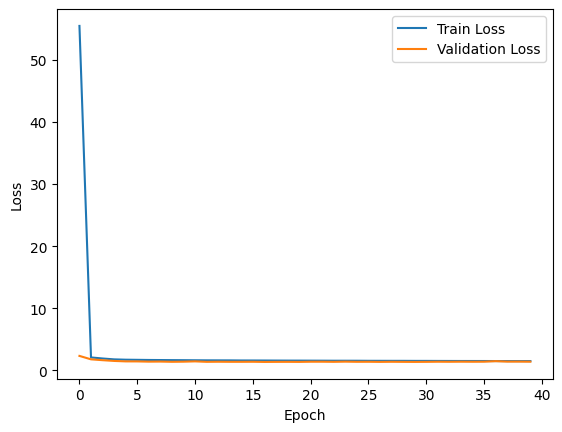

In [17]:
# Plot train and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



print("Using device:", device)

# LSTM Model with Embedding
class LSTMModelWithEmbedding(nn.Module):
    def __init__(self, input_dim, num_cities, embedding_dim, hidden_size, dropout):
        super().__init__()
        self.city_embedding = nn.Embedding(num_embeddings=num_cities, embedding_dim=embedding_dim)
        self.lstm = nn.LSTM(
            input_size=input_dim + embedding_dim,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout)
        self.linear1 = nn.Linear(hidden_size * 2, 64)
        self.linear2 = nn.Linear(64, 8)
        self.output_linear = nn.Linear(8, 1)

    def forward(self, x, city_idx):
        city_emb = self.city_embedding(city_idx).unsqueeze(1).expand(-1, x.size(1), -1)
        x = torch.cat([x, city_emb], dim=2)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Output from the last timestep
        x = self.dropout(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.output_linear(x)
        return x


# Hyperparameters
input_dim = X_train.shape[2]  # Number of features
num_cities = city_train.max().item() + 1  # Total number of unique cities
epochs = 1000
hidden_size=128
dropout=0.39
batch_size = 64
embedding_dim = 7 # Dimension of the embedding layer


# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
city_train_tensor = torch.tensor(city_train, dtype=torch.long).to(device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
city_test_tensor = torch.tensor(city_test, dtype=torch.long).to(device)

# DataLoader for batching
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor, city_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor, city_test_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Using device: cuda


In [25]:
# Recreate the model with the same architecture
model = LSTMModelWithEmbedding(input_dim=input_dim, num_cities=num_cities, embedding_dim=embedding_dim,hidden_size=hidden_size,dropout=dropout).to(device)

# Load the saved checkpoint
checkpoint_path = "/home/research/a.naveen/denoise40/weather/lstm/best_model.pth"
checkpoint = torch.load(checkpoint_path)

# Load model and optimizer state
model.load_state_dict(checkpoint['model_state_dict'])

# Set the model to evaluation mode
model.eval()

LSTMModelWithEmbedding(
  (city_embedding): Embedding(5, 7)
  (lstm): LSTM(38, 128, num_layers=2, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.39, inplace=False)
  (linear1): Linear(in_features=256, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=8, bias=True)
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

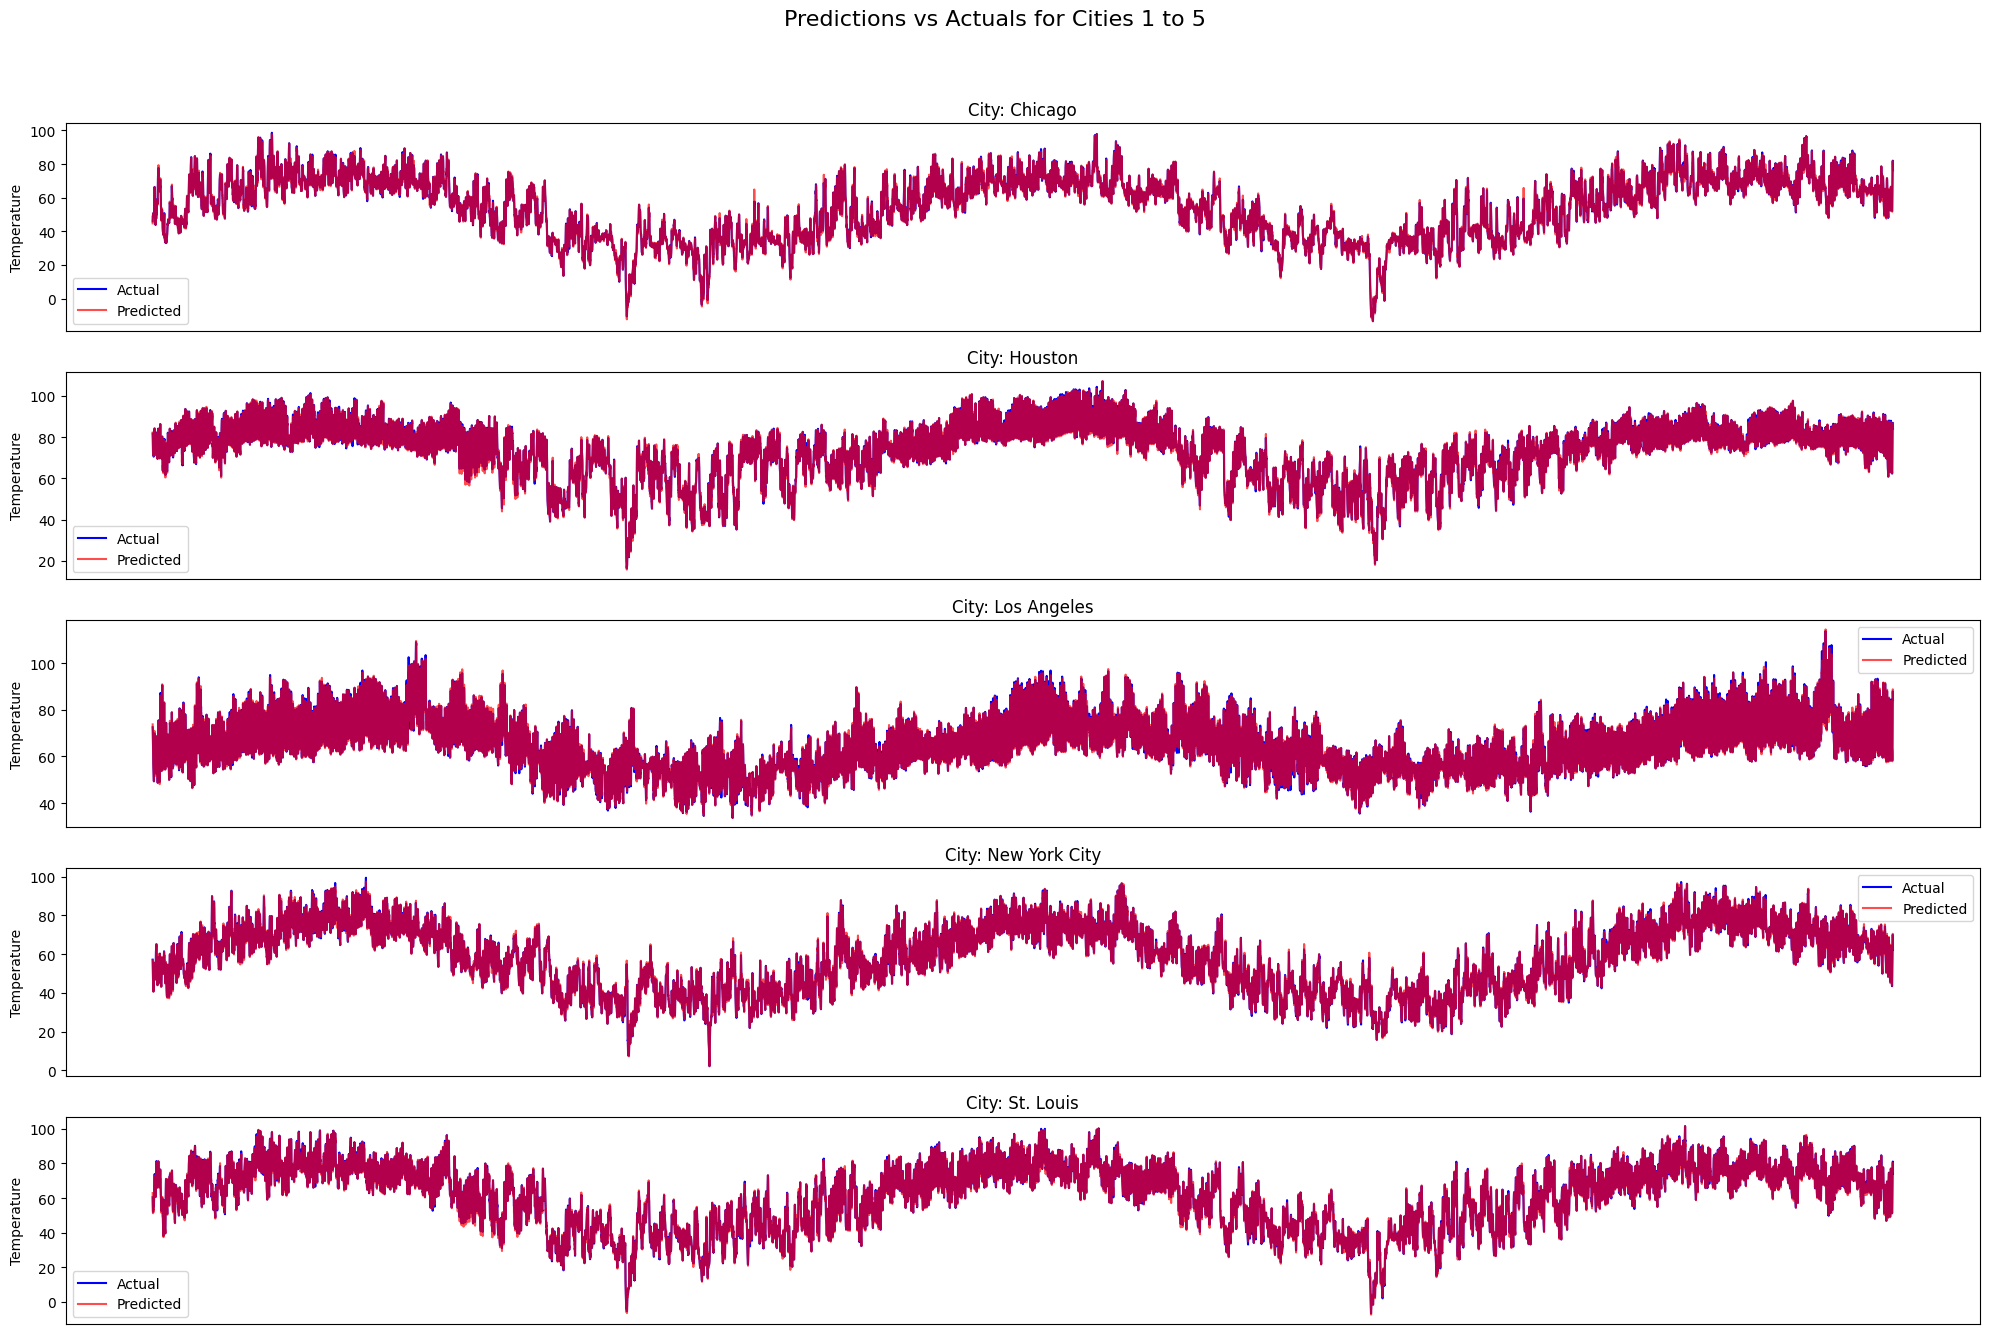

In [26]:
import matplotlib.pyplot as plt
import numpy as np
# Create a mapping between city_idx and location_city
city_mapping = df[['city_idx', 'location_city']].drop_duplicates()



# Create a dictionary to map city_idx to city names
city_name_mapping = dict(zip(city_mapping['city_idx'], city_mapping['location_city']))

# Generate predictions on the test set, grouped by city
model.eval()
predictions = []
actuals = []
city_indices = []

with torch.no_grad():
    for X_batch, y_batch, city_batch in test_loader:
        output = model(X_batch, city_batch)
        predictions.extend(output.cpu().numpy())
        actuals.extend(y_batch.cpu().numpy())
        city_indices.extend(city_batch.cpu().numpy())

# Convert lists to NumPy arrays
predictions = np.array(predictions).squeeze()
actuals = np.array(actuals).squeeze()
city_indices = np.array(city_indices)

# Get unique city indices for plotting city-wise
unique_cities = np.unique(city_indices)
num_cities = len(unique_cities)

# Plot predictions vs actual values for each city with subplots, 5 per figure
cities_per_fig = 5
num_figs = int(np.ceil(num_cities / cities_per_fig))

for fig_num in range(num_figs):
    start_idx = fig_num * cities_per_fig
    end_idx = min(start_idx + cities_per_fig, num_cities)
    cities_to_plot = unique_cities[start_idx:end_idx]
    
    fig, axes = plt.subplots(len(cities_to_plot), 1, figsize=(20, 14))
    fig.suptitle(f'Predictions vs Actuals for Cities {start_idx + 1} to {end_idx}', fontsize=16)
    
    if len(cities_to_plot) == 1:
        axes = [axes]  # Ensure axes is iterable if only one subplot

    for ax, city_id in zip(axes, cities_to_plot):
        city_mask = city_indices == city_id
        city_predictions = predictions[city_mask]
        city_actuals = actuals[city_mask]
        
        # Get city name from mapping
        city_name = city_name_mapping.get(city_id, f"City ID {city_id}")
        
        ax.plot(city_actuals, label='Actual', color='blue')
        ax.plot(city_predictions, label='Predicted', color='red', alpha=0.7)
        ax.set_title(f'City: {city_name}')
        
        ax.set_ylabel('Temperature')
        # Remove x-axis values
        ax.set_xticks([])
        ax.legend()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the title
    plt.show()


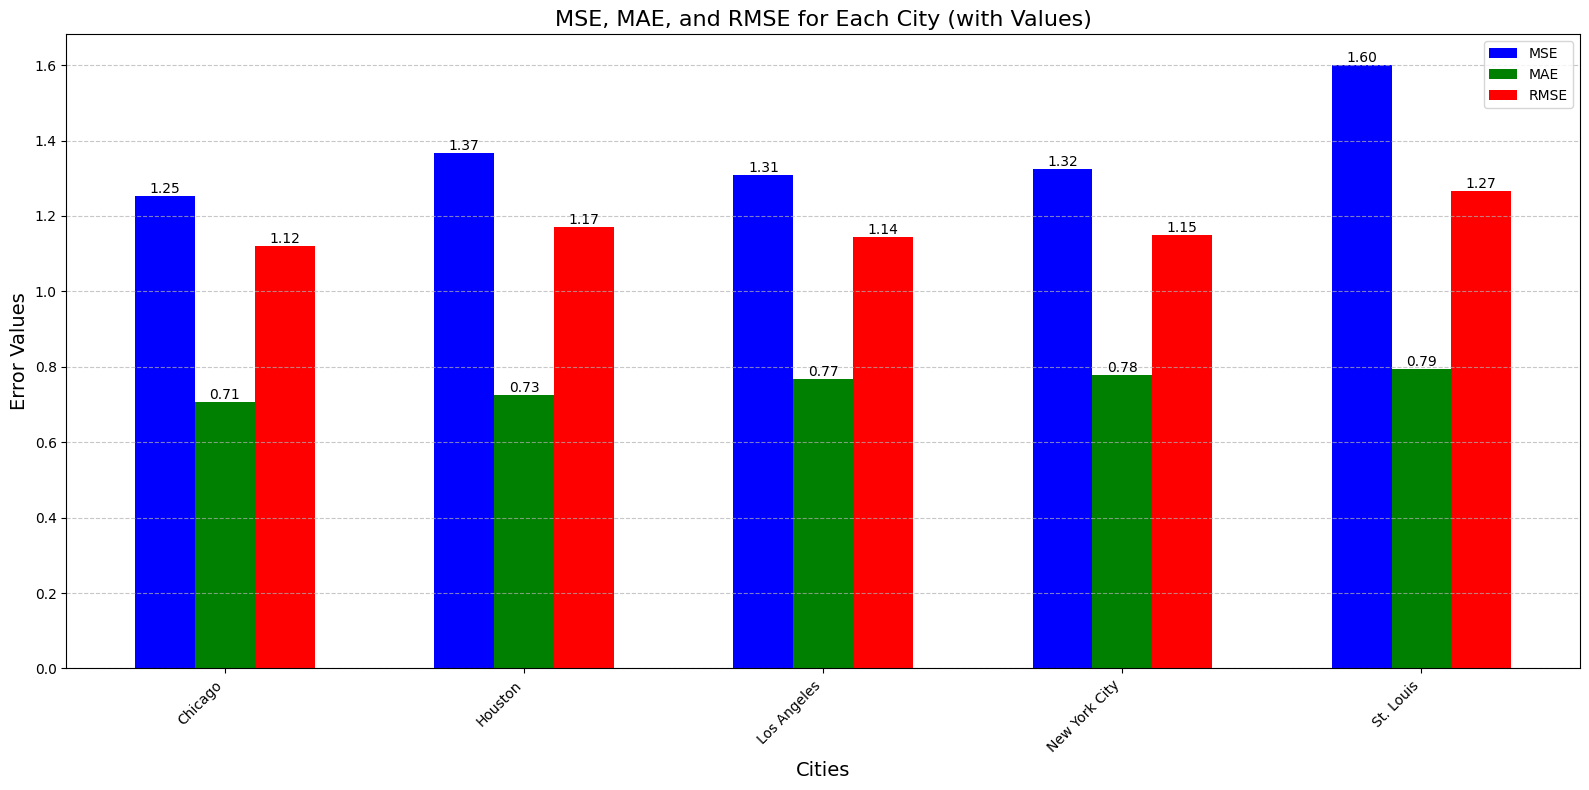

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Create a dictionary to map city_idx to city names
city_name_mapping = dict(zip(city_mapping['city_idx'], city_mapping['location_city']))

# Initialize a dictionary to store metrics for each city
city_metrics = {}

# Loop through each unique city index
for city_id in np.unique(city_indices):
    # Mask to filter data for the current city
    city_mask = city_indices == city_id
    city_predictions = predictions[city_mask]
    city_actuals = actuals[city_mask]
    
    # Calculate metrics
    mse = mean_squared_error(city_actuals, city_predictions)
    mae = mean_absolute_error(city_actuals, city_predictions)
    rmse = np.sqrt(mse)
    
    # Get the city name
    city_name = city_name_mapping.get(city_id, f"City ID {city_id}")
    
    # Store metrics
    city_metrics[city_name] = {
        "MSE": mse,
        "MAE": mae,
        "RMSE": rmse
    }

# Prepare data for plotting
cities = list(city_metrics.keys())
mse_values = [metrics["MSE"] for metrics in city_metrics.values()]
mae_values = [metrics["MAE"] for metrics in city_metrics.values()]
rmse_values = [metrics["RMSE"] for metrics in city_metrics.values()]

# Plot MSE, MAE, and RMSE as bar charts
x = np.arange(len(cities))  # City indices for the x-axis

plt.figure(figsize=(16, 8))

# Plot MSE
mse_bars = plt.bar(x - 0.2, mse_values, width=0.2, label='MSE', color='blue')

# Plot MAE
mae_bars = plt.bar(x, mae_values, width=0.2, label='MAE', color='green')

# Plot RMSE
rmse_bars = plt.bar(x + 0.2, rmse_values, width=0.2, label='RMSE', color='red')

# Add values on top of bars
for bars, values in zip([mse_bars, mae_bars, rmse_bars], [mse_values, mae_values, rmse_values]):
    for bar, value in zip(bars, values):
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # X position (center of the bar)
            bar.get_height(),                  # Y position (top of the bar)
            f"{value:.2f}",                    # Value (rounded to 2 decimal places)
            ha='center', va='bottom', fontsize=10  # Alignment and font size
        )

# Add labels and title
plt.xticks(x, cities, rotation=45, ha='right')
plt.xlabel('Cities', fontsize=14)
plt.ylabel('Error Values', fontsize=14)
plt.title('MSE, MAE, and RMSE for Each City (with Values)', fontsize=16)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


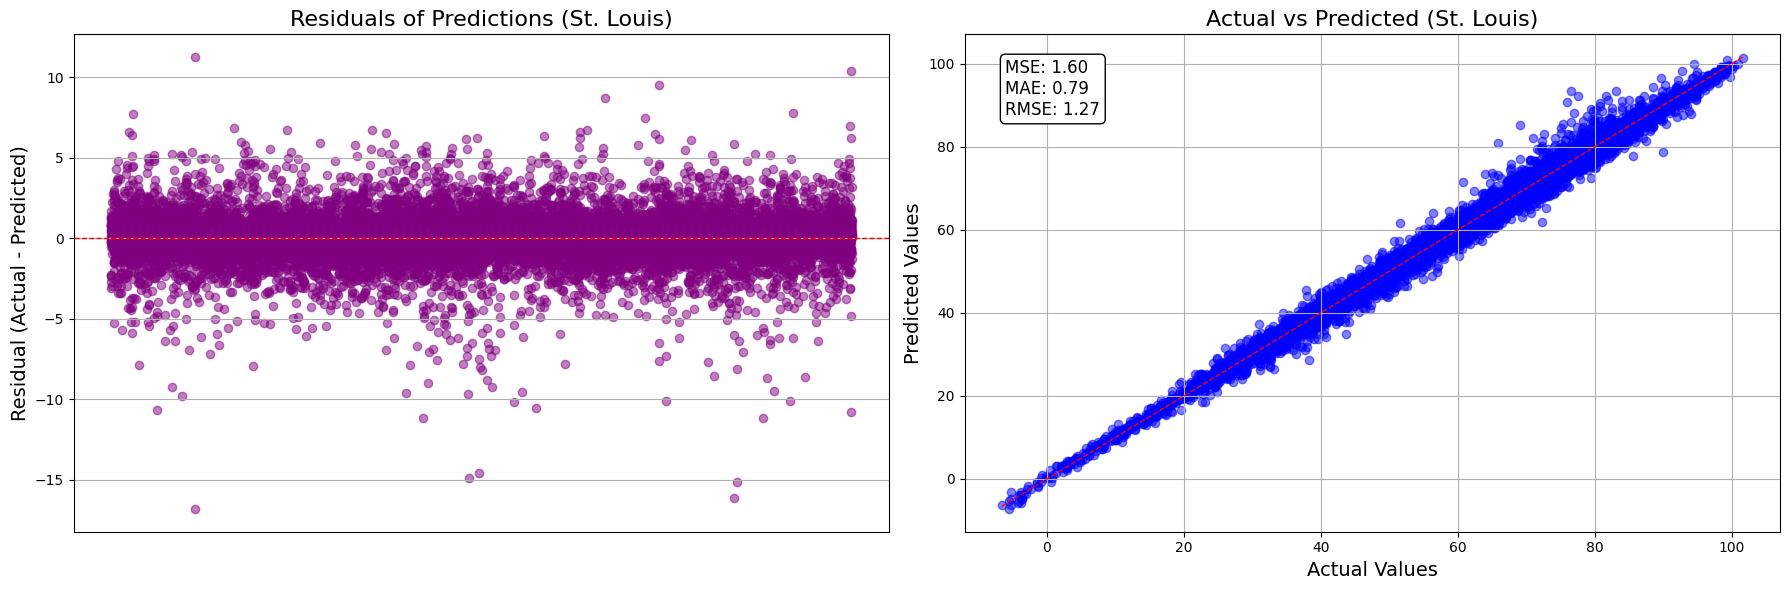

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Identify the city index for St. Louis
st_louis_idx = city_mapping[city_mapping['location_city'] == 'St. Louis']['city_idx'].values[0]

# Filter data for St. Louis
st_louis_mask = city_indices == st_louis_idx
st_louis_actuals = actuals[st_louis_mask]
st_louis_predictions = predictions[st_louis_mask]

# Calculate residuals for St. Louis
st_louis_residuals = st_louis_actuals - st_louis_predictions

# Calculate metrics for St. Louis
mse = mean_squared_error(st_louis_actuals, st_louis_predictions)
mae = mean_absolute_error(st_louis_actuals, st_louis_predictions)
rmse = np.sqrt(mse)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Subplot 1: Residuals for St. Louis
axes[0].scatter(range(len(st_louis_residuals)), st_louis_residuals, alpha=0.5, color='purple')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0].set_title('Residuals of Predictions (St. Louis)', fontsize=16)
axes[0].set_ylabel('Residual (Actual - Predicted)', fontsize=14)
axes[0].grid(True)
axes[0].set_xticks([])  # Remove x-axis values

# Subplot 2: Actual vs Predicted for St. Louis
axes[1].scatter(st_louis_actuals, st_louis_predictions, alpha=0.5, color='blue')
axes[1].plot([min(st_louis_actuals), max(st_louis_actuals)], 
             [min(st_louis_actuals), max(st_louis_actuals)], 
             color='red', linestyle='--', linewidth=1)  # Perfect prediction line
axes[1].set_title('Actual vs Predicted (St. Louis)', fontsize=16)
axes[1].set_xlabel('Actual Values', fontsize=14)
axes[1].set_ylabel('Predicted Values', fontsize=14)
axes[1].grid(True)

# Display error metrics on the second subplot
text_x = 0.05  # X-coordinate for text (relative to axis)
text_y = 0.95  # Y-coordinate for text (relative to axis)
axes[1].text(
    text_x, text_y, 
    f'MSE: {mse:.2f}\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}',
    transform=axes[1].transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
)

# Adjust layout
plt.tight_layout()
plt.show()


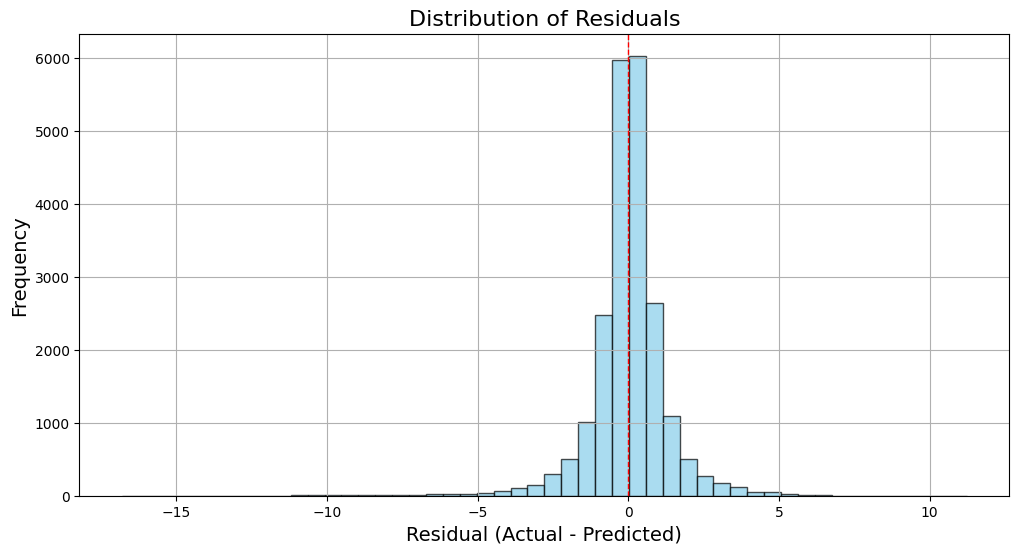

In [31]:
import matplotlib.pyplot as plt

# Plot distribution of residuals
plt.figure(figsize=(12, 6))
plt.hist(st_louis_residuals, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.title('Distribution of Residuals', fontsize=16)
plt.xlabel('Residual (Actual - Predicted)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()


In [32]:
!python -m ipykernel install --user --name=afm --display-name "Python venv"


Installed kernelspec afm in /home/research/a.naveen/.local/share/jupyter/kernels/afm


In [123]:

!conda install ipykernel --prefix /project/cigserver5/export1/a.naveen/venv --yes





Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::libstdcxx-ng==11.2.0=h1234567_1
  - defaults/linux-64::libgcc-ng==11.2.0=h1234567_1
  - defaults/linux-64::bzip2==1.0.8=h5eee18b_6
  - defaults/linux-64::expat==2.6.3=h6a678d5_0
  - defaults/linux-64::libffi==3.4.4=h6a678d5_1
  - defaults/linux-64::libuuid==1.41.5=h5eee18b_0
  - defaults/linux-64::ncurses==6.4=h6a678d5_0
  - defaults/linux-64::openssl==3.0.15=h5eee18b_0
  - defaults/linux-64::tbb==2021.8.0=hdb19cb5_0
  - defaults/linux-64::xz==5.4.6=h5eee18b_1
  - defaults/linux-64::zlib==1.2.13=h5eee18b_1
  - defaults/linux-64::intel-openmp==2023.1.0=hdb19cb5_46306
  - defaults/linux-64::readline==8.2=h5eee18b_0
  - defaults/linux-64::tk==8.6.14=h39e8969_0
  - defaults/linux-64::mkl==2023.1.0=h213fc3f_46344
  - defaults/linux-64::sqlite==3.45.3=h5eee18b_0
  - defaults/linux-64::python==3.12.7=h5148396_0
  - defau

In [124]:
!/project/cigserver5/export1/a.naveen/venv/bin/python -m ipykernel install --user --name=venv --display-name "Python (venv)"


Installed kernelspec venv in /home/research/a.naveen/.local/share/jupyter/kernels/venv


In [1]:
import sys

In [2]:
import torch


ModuleNotFoundError: No module named 'torch'

In [38]:
dates

array(['2000-01-01 00:00:00', '2000-01-01 01:00:00',
       '2000-01-01 02:00:00', ..., '2024-10-11 21:00:00',
       '2024-10-11 22:00:00', '2024-10-11 23:00:00'], dtype=object)